# ML

In [1]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features

In [2]:
df = pd.read_csv("gen/historical_data_1d.csv", sep=';')
df["begin"] = pd.to_datetime(df["begin"])

In [3]:
df.head()

,begin,open,close,high,low,value,volume,name
0,2007-07-20,109.0,109.20,111.11,108.01,2.211623e+09,20252489,SBER
1,2007-07-23,109.7,112.00,112.65,108.10,3.901829e+09,35092029,SBER
2,2007-07-24,112.1,109.53,113.05,109.47,3.536964e+09,31762001,SBER
3,2007-07-25,108.5,109.63,109.98,107.10,4.300853e+09,39700937,SBER
4,2007-07-26,110.0,104.18,110.42,103.30,5.299123e+09,49871205,SBER


Так как в таблице несколько разных временных рядов то выделю из в отдельные дата фреймы

In [4]:
series = {}
for n in df['name'].unique():
    series[n] = df[df['name'] == n].sort_values(by='begin').reset_index(drop=True)
    print(n, len(series[n]))
print(series['T'])

SBER 4619
SBERP 4619
T 1518
MBNK 416
VTBR 4575
CBOM 2637
SVCB 515
          begin    open   close    high     low         value   volume name
0    2019-10-28  1186.0  1206.0  1212.0  1186.0  2.454623e+08   204766    T
1    2019-10-29  1202.0  1219.8  1226.0  1200.2  8.288816e+07    68382    T
2    2019-10-30  1225.0  1217.0  1227.0  1212.8  4.465658e+07    36691    T
3    2019-10-31  1221.4  1216.0  1223.8  1210.2  2.346928e+07    19326    T
4    2019-11-01  1218.4  1214.0  1219.0  1212.6  2.021542e+07    16625    T
...         ...     ...     ...     ...     ...           ...      ...  ...
1513 2025-10-09  2921.8  2959.0  2976.2  2810.0  1.512272e+10  5186340    T
1514 2025-10-10  2964.6  2899.8  2964.6  2885.2  6.444373e+09  2202172    T
1515 2025-10-11  2894.0  2894.0  2895.8  2875.8  3.329201e+08   115329    T
1516 2025-10-12  2900.0  2908.6  2915.6  2898.8  2.394923e+08    82349    T
1517 2025-10-13  2915.6  2910.0  2938.6  2872.0  5.759586e+09  1978461    T

[1518 rows x 8 column

Для обучения базовый модели приведу все ряды к одинаковой длине - 1200 значений, что бы исключить IPO Т банка.

In [5]:
del series['MBNK']
del series['SVCB']

In [6]:
for key, val in series.items():
    series[key] = val.tail(1200).reset_index(drop=True)

print(series['T'])

          begin    open   close    high     low         value   volume name
0    2021-02-05  3208.0  3254.8  3278.6  3174.0  8.136495e+08   252349    T
1    2021-02-08  3260.2  3400.0  3409.6  3260.0  1.317999e+09   394465    T
2    2021-02-09  3429.6  3474.6  3495.0  3300.2  2.303194e+09   671002    T
3    2021-02-10  3576.2  3594.6  3691.0  3511.0  6.012118e+09  1678973    T
4    2021-02-11  3626.0  3530.6  3628.0  3503.8  1.759401e+09   495260    T
...         ...     ...     ...     ...     ...           ...      ...  ...
1195 2025-10-09  2921.8  2959.0  2976.2  2810.0  1.512272e+10  5186340    T
1196 2025-10-10  2964.6  2899.8  2964.6  2885.2  6.444373e+09  2202172    T
1197 2025-10-11  2894.0  2894.0  2895.8  2875.8  3.329201e+08   115329    T
1198 2025-10-12  2900.0  2908.6  2915.6  2898.8  2.394923e+08    82349    T
1199 2025-10-13  2915.6  2910.0  2938.6  2872.0  5.759586e+09  1978461    T

[1200 rows x 8 columns]


для прогноза нужно выбрать параметр для прогнозирования. Лучше всего взять комбинированный параметр из ohlc данных. Мне кажется лучше всего будет взять среднее по всем параметрам ohlc, но здесь есть поле для эксперементов. 

In [7]:
def IntradayReturn(df):
    return df['close']/df['open'] - 1

def OvernightReturn(df):
    return df['open']/df['close'].shift(1) - 1

def Amplitude(df):
    return (df['high'] - df['low']) / ((df['high'] + df['low']) / 2)

def OHLC(df):
    return (df['open'] + df['close'] + df['low'] + df['high'])/4.0

def MedianPrice(df):
    return (df['low'] + df['high'])/2.0

def BodyMedian(df):
    return (df['open'] + df['close'])/2.0

In [8]:
for s in series:
    series[s]['intraday'] = IntradayReturn(series[s])
    series[s]['overnight'] = OvernightReturn(series[s])
    series[s]['amplitude'] = Amplitude(series[s])

    series[s]['ohlc'] = OHLC(series[s])
    series[s]['MedianPrice'] = MedianPrice(series[s])
    series[s]['BodyMedian'] = BodyMedian(series[s])

In [9]:
def RollingVolatility(df, window):
    ret = np.log(df['close']).diff()
    return ret.rolling(window=window).std() * np.sqrt(252)

def VolatilityParkinson(df, window):
    ret = (1.0 / (4.0 * math.log(2.0))) * ((df["high"] / df["low"]).apply(np.log)) ** 2.0
    return ret.rolling(window=window).apply(lambda x : (252 * x.mean()) ** 0.5)

def VolatilityGarmanKlass(df, window):
    log_hl = (df["high"] / df["low"]).apply(np.log)
    log_co = (df["close"] / df["open"]).apply(np.log)
    ret = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2
    return ret.rolling(window=window).apply(lambda x : (252 * x.mean()) ** 0.5)

for s in series:
    series[s]['RollingVolatility_7d'] = RollingVolatility(series[s], 7)
    series[s]['RollingVolatility_30d'] = RollingVolatility(series[s], 30)
    
    series[s]['VolatilityParkinson_7d'] = VolatilityParkinson(series[s], 7)
    series[s]['VolatilityParkinson_30d'] = VolatilityParkinson(series[s], 30)
    
    series[s]['VolatilityGarmanKlass_7d'] = VolatilityGarmanKlass(series[s], 7)
    series[s]['VolatilityGarmanKlass_30d'] = VolatilityGarmanKlass(series[s], 30)

In [10]:
def RSI(df, period = 14):
    delta = df.diff()

    up = delta.where(delta > 0, 0.0)
    down = -delta.where(delta < 0, 0.0)

    roll_up = pd.Series(up).ewm(alpha=1 / period, adjust=False).mean()
    roll_down = pd.Series(down).ewm(alpha=1 / period, adjust=False).mean()

    return 100.0 - (100.0 / (1.0 + roll_up / roll_down))

def MACD(df, fast = 12, slow = 26, signal = 9):
    ema_fast = df.ewm(span=fast, adjust=False).mean()
    ema_slow = df.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist


for s in series:
    series[s]['SMA_20'] = series[s]['close'].rolling(window=20).mean()
    series[s]['SMA_60'] = series[s]['close'].rolling(window=60).mean()

    series[s]['EMA_20'] = series[s]['close'].ewm(span=20, adjust=False).mean()
    series[s]['EMA_60'] = series[s]['close'].ewm(span=60, adjust=False).mean()

    series[s]['RSI_14'] = RSI(series[s]['close'], period=14)
    series[s]['MACD'], series[s]['MACD_signal'], series[s]['MACD_hist'] = MACD(series[s]['close'])


Все фичи из ЕДА перенесы теперь разобьем выборку на трен и тест. Так как некоторые индикаторы не определены в начале, то эти части нужно убрать из выборки.

In [11]:
series['T'].isna().sum().max()

59

In [12]:
series['SBER'].head()

,begin,open,close,high,low,value,volume,name,intraday,overnight,...,VolatilityGarmanKlass_7d,VolatilityGarmanKlass_30d,SMA_20,SMA_60,EMA_20,EMA_60,RSI_14,MACD,MACD_signal,MACD_hist
0,2021-03-12,286.30,284.93,287.49,282.82,1.469694e+10,51540190,SBER,-0.004785,NaN,...,NaN,NaN,NaN,NaN,284.930000,284.930000,NaN,0.000000,0.000000,0.000000
1,2021-03-15,286.05,292.74,292.92,285.28,1.969448e+10,67805740,SBER,0.023388,0.003931,...,NaN,NaN,NaN,NaN,285.673810,285.186066,100.000000,0.623020,0.124604,0.498416
2,2021-03-16,293.06,292.33,293.88,288.61,1.570696e+10,53921730,SBER,-0.002491,0.001093,...,NaN,NaN,NaN,NaN,286.307732,285.420293,94.649017,1.071334,0.313950,0.757384
3,2021-03-17,292.35,283.35,293.25,279.60,3.142031e+10,110292330,SBER,-0.030785,0.000068,...,NaN,NaN,NaN,NaN,286.026044,285.352414,41.840303,0.694016,0.389963,0.304053
4,2021-03-18,284.04,279.25,285.79,278.24,2.095219e+10,74128740,SBER,-0.016864,0.002435,...,NaN,NaN,NaN,NaN,285.380706,285.152335,32.833041,0.063421,0.324655,-0.261234


пострю дополнительные признаки для этого ряда

с помощью tsfresh добавлю признаки которые описывают временной ряд 

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [14]:
sym = "SBER"
df = series[sym].copy()
df = df.tail(len(df) - series[sym].isna().sum().max()).reset_index(drop=True)



timestamp = df['begin'].iloc[1:]
X = df.drop(columns=['begin', 'name']).iloc[:-1]
y = df['ohlc'].shift(-1).iloc[:-1]

X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
    X, y, timestamp, test_size=0.1, shuffle=False
)
y_pred_naive = df['ohlc'].shift(1).tail(len(y_test))
print("Total:", len(X), ", Train:", len(X_train), ", Test:", len(X_test))

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])


pipe_ridge.fit(X_train, y_train)
y_pred_ridge = pipe_ridge.predict(X_test)

Total: 1140 , Train: 1026 , Test: 114


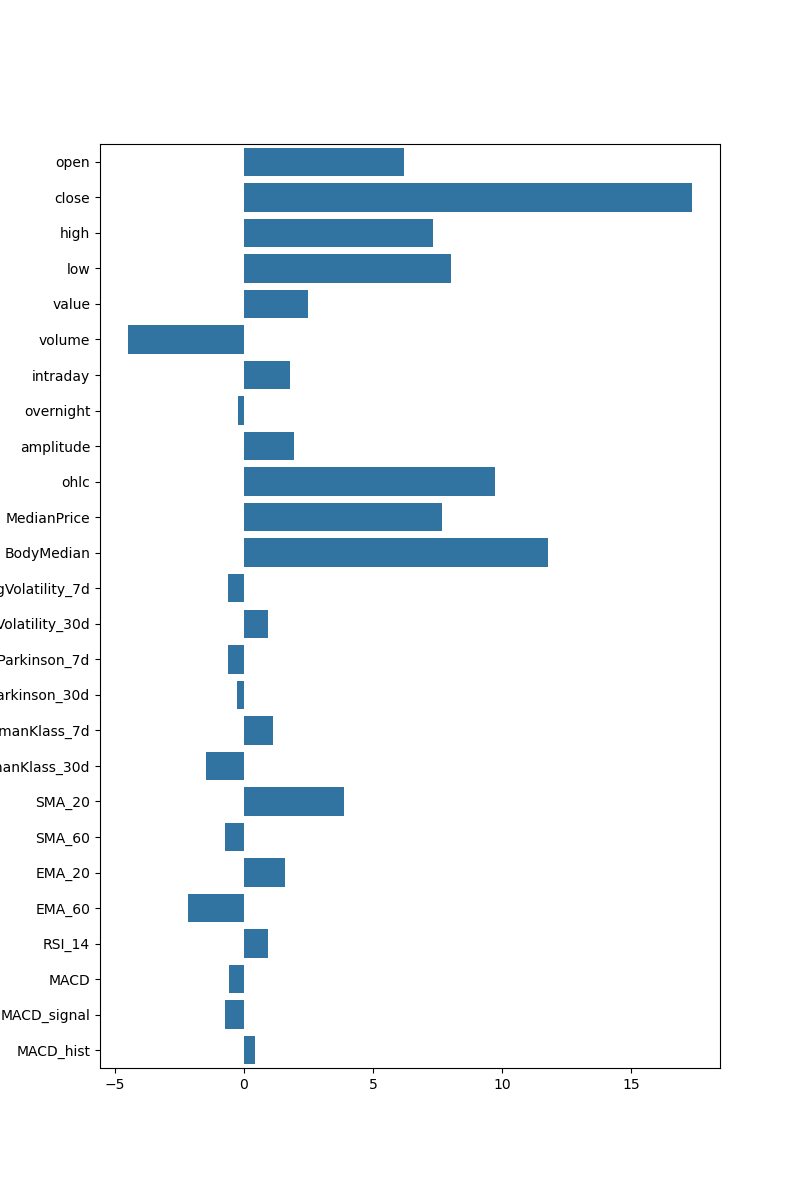

In [15]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x=pipe_ridge['model'].coef_.ravel(), y=X.columns, ax=ax)
plt.show()

In [16]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sym = "SBER"
df = series[sym].copy()

h = 7
df_bt = df.copy()
cols = df.columns.tolist()
cols.remove('begin')
cols.remove('name')
for c in cols:
    for i in range(1, h+1):
        df[f'{c}_{str(i)}'] = df[c].shift(i)
df = df.tail(len(df) - df.isna().sum().max()).reset_index(drop=True)

timestamp = df['begin'].iloc[1:]
X = df.drop(columns=['begin', 'name']).iloc[:-1]
y = df['ohlc'].shift(-1).iloc[:-1]


X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
    X, y, timestamp, test_size=0.1, shuffle=False
)

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])


pipe_ridge.fit(X_train, y_train)
y_pred_ridge_extended_features = pipe_ridge.predict(X_test)

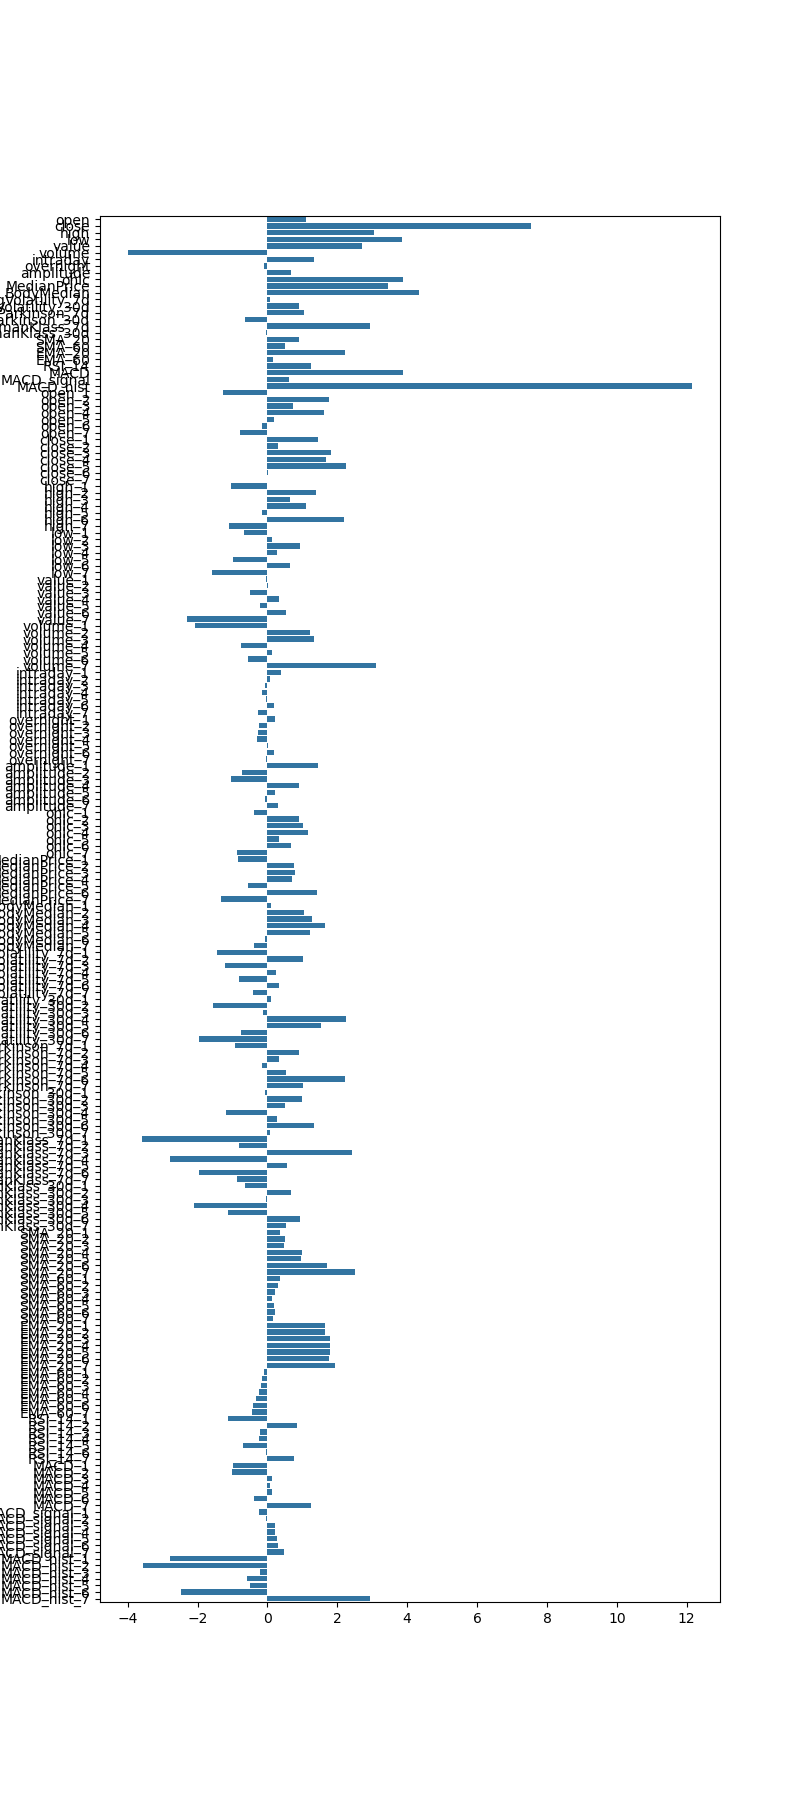

In [17]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,18))
sns.barplot(x=pipe_ridge['model'].coef_.ravel(), y=X.columns, ax=ax)
plt.show()

In [18]:
import numpy as np
import pandas as pd

from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

def make_tsfresh_supervised(
    df: pd.DataFrame,
    time_col="begin",
    target_col="ohlc",
    value_cols=("close", "volume"),   # choose what you want tsfresh to analyze
    window=30,                        # days in the past used to compute features
    horizon=1,                        # predict t+horizon
    fc_params=None,                   # MinimalFCParameters() is fast baseline
    n_jobs=1,
):
    df = df.sort_values(time_col).reset_index(drop=True).copy()

    # build rolling windows in LONG format: [id, time, kind, value]
    chunks = []
    ys = []
    ts = []

    last_t = len(df) - horizon - 1
    for t in range(window - 1, last_t + 1):
        w = df.loc[t - window + 1 : t, [time_col, *value_cols]].copy()
        w["id"] = t
        w_long = w.melt(
            id_vars=["id", time_col],
            var_name="kind",
            value_name="value",
        ).rename(columns={time_col: "time"})
        chunks.append(w_long)

        ys.append(df.loc[t + horizon, target_col])
        ts.append(df.loc[t + horizon, time_col])  # timestamp of the predicted point

    long_df = pd.concat(chunks, axis=0, ignore_index=True)
    if fc_params is None:
        fc_params = MinimalFCParameters()

    X = extract_features(
        long_df,
        column_id="id",
        column_sort="time",
        column_kind="kind",
        column_value="value",
        default_fc_parameters=fc_params,
        n_jobs=n_jobs,
    )

    # tsfresh often produces NaNs/Infs -> impute
    X = X.replace([np.inf, -np.inf], np.nan)
    impute(X)

    y = pd.Series(ys, index=X.index, name=f"{target_col}_t+{horizon}")
    ts = pd.Series(ts, index=X.index, name="timestamp")

    return X, y, ts


X, y, timestamp = make_tsfresh_supervised(
    df,
    time_col="begin",
    target_col="ohlc",
    value_cols=("close", "volume"),  # start small; add more later
    window=30,
    horizon=1,
    n_jobs=1,                        # increase if your tsfresh supports it well
)

X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
    X, y, timestamp, test_size=0.1, shuffle=False
)

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42)),
])


pipe_ridge.fit(X_train, y_train)
y_pred_ridge_tsfresh = pipe_ridge.predict(X_test)

Feature Extraction: 100%|██████████| 2208/2208 [00:00<00:00, 9438.19it/s]


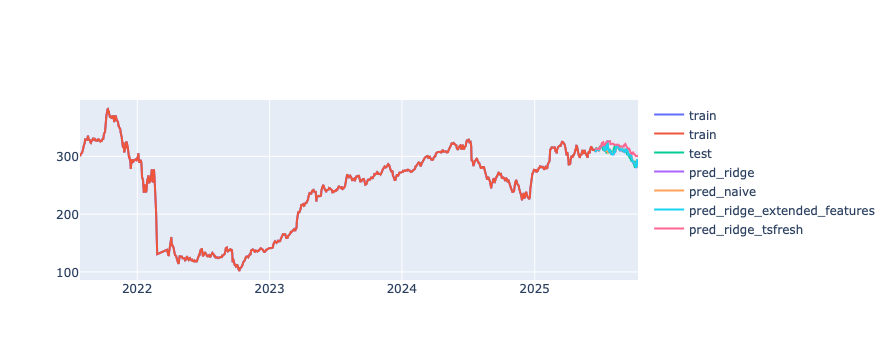

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ts_train, 
    y=y_train, 
    mode='lines', 
    name='train'
))

fig.add_trace(go.Scatter(
    x=ts_train, 
    y=y_train, 
    mode='lines', 
    name='train'
))

fig.add_trace(go.Scatter(
    x=ts_test, 
    y=y_test, 
    mode='lines', 
    name='test'
))

fig.add_trace(go.Scatter(
    x=ts_test, 
    y=y_pred_ridge, 
    mode='lines', 
    name='pred_ridge'
))

fig.add_trace(go.Scatter(
    x=ts_test, 
    y=y_pred_naive, 
    mode='lines', 
    name='pred_naive'
))

fig.add_trace(go.Scatter(
    x=ts_test, 
    y=y_pred_ridge_extended_features, 
    mode='lines', 
    name='pred_ridge_extended_features'
))

fig.add_trace(go.Scatter(
    x=ts_test, 
    y=y_pred_ridge_tsfresh, 
    mode='lines', 
    name='pred_ridge_tsfresh'
))


fig.show()